In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine
from scipy.stats import zscore
import matplotlib.pyplot as plt
import joblib
import logging
from datetime import datetime
import seaborn as sns
logging.basicConfig(level=logging.INFO)


In [5]:
class SalesPerformancePrediction:
    def __init__(self):
        self.label_encoders = {}
        self.models = {}
        self.scaler = StandardScaler()

    def fetch_data_from_sql(self, query, server, database):
        """
        Fetch data from SQL Server using SQLAlchemy
        """
        logging.info("Fetching data from SQL Server...")
        engine = create_engine(f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")
        data = pd.read_sql_query(query, engine)
        return data

    def prepare_data(self, fact_sales, dim_product, dim_date, dim_territory):
        """
        Merge dimension tables with fact_sales and calculate metrics
        """
        logging.info("Merging dimension tables with fact_sales...")
        sales_data = fact_sales.merge(dim_product, on='ProductKey')\
                            .merge(dim_date, on='DateKey')\
                            .merge(dim_territory, on='TerritoryKey')


        # Handle missing and invalid values
        logging.info("Handling missing and invalid values...")
        sales_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        sales_data.fillna(0, inplace=True)


        # Remove outliers
        logging.info("Removing outliers...")
        sales_data['Revenue'] = sales_data['OrderQty'] * sales_data['UnitPrice']
        sales_data = sales_data[(np.abs(zscore(sales_data['Revenue'])) < 3)]
        sales_data = sales_data.drop(['Revenue'], axis=1)

        return sales_data

In [6]:
# Database Connection Details
server = "DESKTOP-TGOL65T"
database = "CompanyXdwh_real"

# Queries
fact_sales_query = "SELECT * FROM fact_sales"
dim_product_query = "SELECT * FROM dim_product"
dim_date_query = "SELECT * FROM dim_date"
dim_territory_query = "SELECT * FROM dim_territory"

# Initialize Class
prediction = SalesPerformancePrediction()

# Fetch Data
fact_sales = prediction.fetch_data_from_sql(fact_sales_query, server, database)
dim_product = prediction.fetch_data_from_sql(dim_product_query, server, database)
dim_date = prediction.fetch_data_from_sql(dim_date_query, server, database)
dim_territory = prediction.fetch_data_from_sql(dim_territory_query, server, database)

# Prepare Data
sales_data = prediction.prepare_data(fact_sales, dim_product, dim_date, dim_territory)


INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Merging dimension tables with fact_sales...
INFO:root:Handling missing and invalid values...
INFO:root:Removing outliers...


In [7]:
sales_data.head()

,SalesKey,SalesOrderID,ProductKey,DateKey,TerritoryKey,StoreKey,CustomerKey,OrderQty,UnitPrice,LineTotal,...,Month,Quarter,Year,TerritoryID,Name,Country,Group,SalesYTD,SalesLastYear,ModifiedDate
0,1,43697-353,254,891,6,0.0,10777.0,1,3578.2700,3578.2700,...,5,2,2011,6,Canada,Canada,North America,6.771829e+06,5.693989e+06,2008-04-30
1,2,43698-354,278,891,7,0.0,17401.0,1,3399.9900,3399.9900,...,5,2,2011,7,France,France,Europe,4.772398e+06,2.396540e+06,2008-04-30
2,3,43699-355,278,891,1,0.0,14874.0,1,3399.9900,3399.9900,...,5,2,2011,1,Northwest,United States,North America,7.887187e+06,3.298694e+06,2008-04-30
3,4,43700-356,272,891,4,0.0,3505.0,1,699.0982,699.0982,...,5,2,2011,4,Southwest,United States,North America,1.051085e+07,5.366576e+06,2008-04-30
4,5,43701-357,278,891,9,0.0,4.0,1,3399.9900,3399.9900,...,5,2,2011,9,Australia,Australia,Pacific,5.977815e+06,2.278549e+06,2008-04-30


In [8]:
sales_data.columns

Index(['SalesKey', 'SalesOrderID', 'ProductKey', 'DateKey', 'TerritoryKey',
       'StoreKey', 'CustomerKey', 'OrderQty', 'UnitPrice', 'LineTotal',
       'TotalDue', 'ModifiedDate_x', 'ProductID', 'ProductName', 'Category',
       'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'ModifiedDate_y',
       'Day', 'Week', 'Month', 'Quarter', 'Year', 'TerritoryID', 'Name',
       'Country', 'Group', 'SalesYTD', 'SalesLastYear', 'ModifiedDate'],
      dtype='object')

In [21]:
df = sales_data

In [22]:
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.drop(['SalesOrderID', 'ModifiedDate', 'Name',
       'Country', 'Group', 'ModifiedDate_x', 'ProductID', 'ProductName', 'SalesKey', 'ProductKey', 'DateKey', 'TerritoryKey',
       'StoreKey', 'CustomerKey', 'Day', 'Week', 'Month', 'Quarter', 'Year', 'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'ModifiedDate_y',], axis=1)

In [24]:
df.to_csv('sales_data.csv', index=None)

In [11]:
def grouped(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(OrderQty = (col, 'sum'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [12]:
def add_lag(df, key, freq, col, lag):
    """ ADD LAG """
    df_grouped = grouped(df, key, freq, col)
    name = 'Lag_' + str(lag)
    df_grouped['Lag'] = df_grouped['OrderQty'].shift(lag)
    return df_grouped

In [18]:
def split_into_train_test(df, key, freq, col):
    # Sort by datetime
    df_grouped = add_lag(df, key, freq, col, 1)
    df_grouped = df_grouped.sort_values(by=key)

    #split train and test
    test_size = None
    if freq == 'D':
        test_size = 30
    elif freq == 'W':
        test_size = 4
    elif freq == 'ME':
        test_size = 1
        
    
    test = df_grouped.tail(test_size)  
    train = df_grouped.iloc[:-test_size] 

    # Reset index (optional)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    return train, test


In [19]:
df_grouped_train_w, df_grouped_test_w = split_into_train_test(df, 'datetime', 'W', 'OrderQty')
df_grouped_train_w

,datetime,OrderQty,Lag
0,2011-06-05,620,NaN
1,2011-06-12,25,620.0
2,2011-06-19,33,25.0
3,2011-06-26,40,33.0
4,2011-07-03,1719,40.0
...,...,...,...
153,2014-05-11,1396,10742.0
154,2014-05-18,1308,1396.0
155,2014-05-25,1354,1308.0
156,2014-06-01,1057,1354.0


In [20]:
df_grouped_train_m, df_grouped_test_m = split_into_train_test(df, 'datetime', 'ME', 'OrderQty')
df_grouped_train_m

,datetime,OrderQty,Lag
0,2011-05-31,600,NaN
1,2011-06-30,141,600.0
2,2011-07-31,1840,141.0
3,2011-08-31,2407,1840.0
4,2011-09-30,157,2407.0
5,2011-10-31,4303,157.0
6,2011-11-30,230,4303.0
7,2011-12-31,921,230.0
8,2012-01-31,3205,921.0
9,2012-02-29,1269,3205.0


ValueError: x and y must have same first dimension, but have shapes (1,) and (158,)

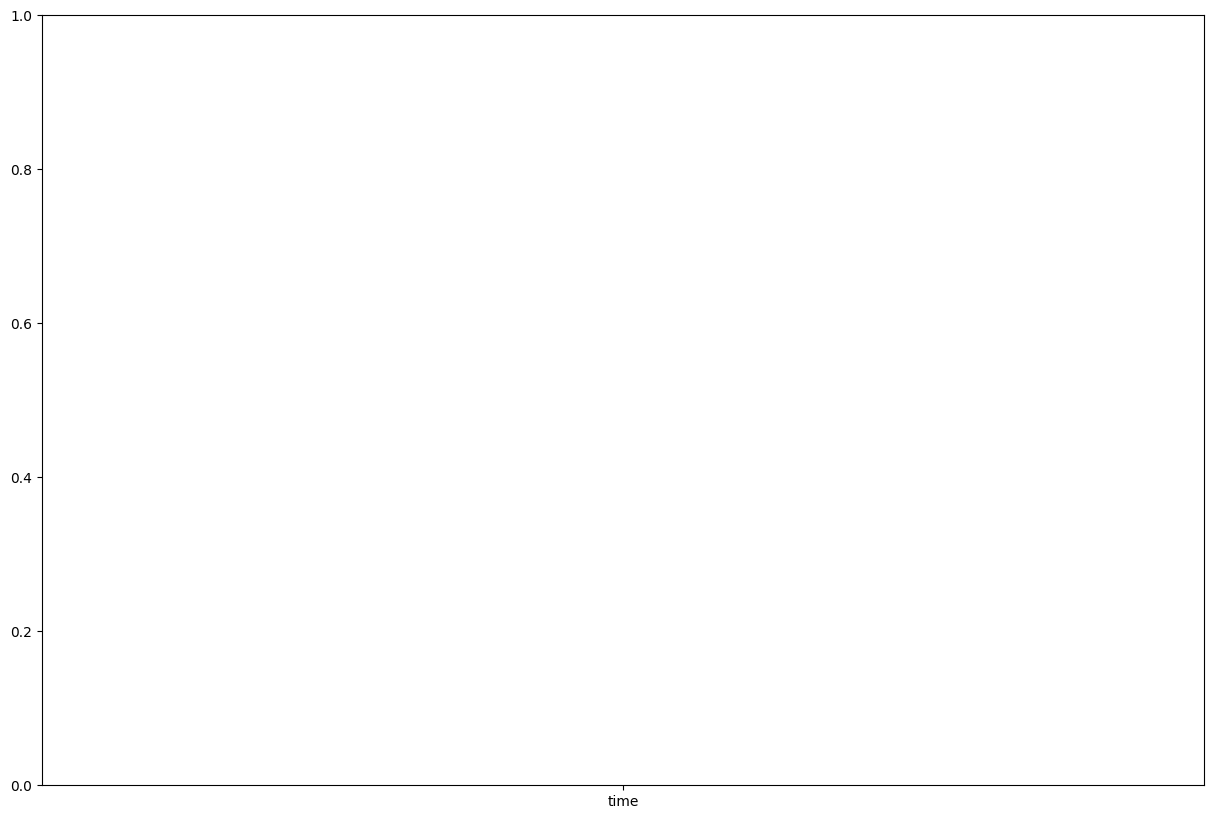

In [13]:
# Plot and save weekly sales graph
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot('time', 'OrderQty', data=df_grouped_train_w, color='blue', label='Weekly Sales')
ax.set_title("Sales (grouped by Week)", fontsize=20)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Order Quantity", fontsize=15)
sns.regplot(
    x='time',
    y='OrderQty',
    data=df_grouped_train_w,
    scatter_kws=dict(color='blue'),
    line_kws={"color": "red"},
    ax=ax
)
ax.legend()
plt.tight_layout()
plt.savefig("sales_grouped_by_week.png")  # Save the weekly plot
plt.close(fig)  # Close the figure to release memory

# Plot and save monthly sales graph
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot('time', 'OrderQty', data=df_grouped_train_m, color='blue', label='Monthly Sales')
ax.set_title("Sales (grouped by Month)", fontsize=20)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Order Quantity", fontsize=15)
sns.regplot(
    x='time',
    y='OrderQty',
    data=df_grouped_train_m,
    scatter_kws=dict(color='blue'),
    line_kws={"color": "red"},
    ax=ax
)
ax.legend()
plt.tight_layout()
plt.savefig("sales_grouped_by_month.png")  # Save the monthly plot
plt.close(fig)  # Close the figure to release memory